## In this notebook, We will present the results of unsupervised clustering, TLS and chemokine score, which will be used to identify TLS. 

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import warnings
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
warnings.filterwarnings("ignore")

mycolor16 = ["#BFE2E3","#A1CFFA","#78BDAD","#D45651","#397A7F","#F0918E","#EEE8DA","#1F5392","#A0BFAF","#AE98D6","#ECCBDC","#54BAD3","#8b4a4b","#DB896C","#AABAC2","#ffae3b",'#03A464','#FF7F00','#8968CD','#1C5B75','#B03060','#00ABDC','#D2691E']
Sizef = 2
backcolor = '#999999'
cm = plt.cm.Spectral_r

In [30]:
### plot functions


def prepare_dfplot(df_meta):
    ### reformat the metadata
    ###
    df_pos = df_meta[['row', 'col']]
    df_meta = df_meta.drop(['row', 'col'], axis=1)
    df_pos = df_pos[['row', 'col']]
    df_pos['row'] = df_pos['row'] - min(df_pos['row']) + 1         
    df_pos['col'] = df_pos['col'] - min(df_pos['col']) + 1

    # 将行列交换
    df_pos['tmp'] = df_pos['row'].copy()
    df_pos['row'] = df_pos['col']
    df_pos['col'] = df_pos['tmp']
    df_pos = df_pos.drop('tmp', axis=1)     
    df_pos['col'] = max(df_pos['col']) + 1 - df_pos['col']

    spot_row = max(df_pos['row']) - min(df_pos['row']) + 1       
    spot_col = max(df_pos['col']) - min(df_pos['col']) + 1
    max_spot = max(spot_row, spot_col)

    df_plot = pd.merge(df_pos, df_meta, left_index=True, right_index=True)
    return df_plot, spot_row, spot_col

def FillHole(im_in):
    ### Fill holes in tissue edgelines
    ###
    im_floodfill = im_in.copy()
    h, w = im_in.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    isbreak = False
    for i in range(im_floodfill.shape[0]):
        for j in range(im_floodfill.shape[1]):
            if(im_floodfill[i][j]==0):
                seedPoint=(i,j)
                isbreak = True
                break
        if(isbreak):
            break
    cv2.floodFill(im_floodfill, mask,seedPoint, 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = im_in | im_floodfill_inv
    return im_out

def get_edge_XY(df_plot, spot_row, spot_col):
    ### get the tissue edgeline
    ###
    bin_f = np.full((spot_col+2, spot_row+2), 0, dtype="uint8")
    bin_f[df_plot['col'].values, df_plot['row'].values] = 255
    bin_f = FillHole(bin_f)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))  
    erode = cv2.dilate(bin_f, kernel) 
    edge = erode - bin_f               
    edgeXY = np.where(edge == 255) 
    return edgeXY

def dimplot_inhouse(df_plot, item, prefix, plot_order, cols=mycolor16, legend=True):
    ### spatial plot for discrete variables
    ###
    cur_dic = {plot_order[idx]: cols[int(idx)] for idx in range(len(plot_order))}
    print(cur_dic)

    fig, ax = plt.subplots(figsize=(Sizef * spot_row / spot_col, Sizef))
    ax.set_xlim((0 ,spot_row+3))
    ax.set_ylim((0, spot_col+3))
    r = 0.55
    r_ = ax.transData.transform([r,0])[0] - ax.transData.transform([0,0])[0]
    marker_size = np.pi * r_**2

    for cur_item in cur_dic.keys():
        df_highlight = df_plot[df_plot[item] == cur_item]
        ax.scatter(x=df_highlight['row']+1, y=df_highlight['col']+1, c=cur_dic[cur_item], s=marker_size, edgecolors='none', label=cur_item)
    back_ind = df_plot.copy()
    for cur_item in cur_dic.keys():
        back_ind = back_ind[back_ind[item] != cur_item]
    ax.scatter(x=back_ind['row']+1, y=back_ind['col']+1, c=backcolor, s=marker_size, edgecolors='none')
    ax.scatter(x=edgeXY[1]+1, y=edgeXY[0]+1, c="#000000", s=marker_size, edgecolors="none")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, hspace=0.1, wspace=0.1)
    if legend:
        plt.legend(prop={'family':'SimHei','size':6},markerscale=4)
    # ax.figure.savefig(f'{prefix}.pdf', bbox_inches='tight')
    plt.show()

def featureplot_inhouse(df_plot, item, prefix):
    ### spatial plot for continuous variables
    ###
    fig, ax = plt.subplots(figsize=(Sizef * spot_row / spot_col, Sizef))
    ax.set_xlim((0 ,spot_row+3))
    ax.set_ylim((0, spot_col+3))
    r = 0.55
    r_ = ax.transData.transform([r,0])[0] - ax.transData.transform([0,0])[0]
    marker_size = np.pi * r_**2
    ax.scatter(x=df_plot['row']+1, y=df_plot['col']+1, c=list(df_plot[item]), s=marker_size, edgecolors='black', linewidth=0, cmap=cm)
    ax.scatter(x=edgeXY[1]+1, y=edgeXY[0]+1, c="#000000", s=marker_size, edgecolors='black', linewidth=0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, hspace=0.1, wspace=0.1)
    # ax.figure.savefig(f'{prefix}.tissueedge.pdf')
    plt.show()

In [31]:
# load data
df = pd.read_csv('/data/yuchen_data/Stereo_seq/All_Figures/TLS_identification/ST2976T.final.meta.txt', index_col=0, sep='\t')

In [32]:
df_plot, spot_row, spot_col = prepare_dfplot(df)
edgeXY = get_edge_XY(df_plot, spot_row, spot_col)

### First, we'll present the results of unsupervised clustering

{0: '#BFE2E3', 1: '#A1CFFA', 2: '#78BDAD', 3: '#D45651', 4: '#397A7F', 5: '#F0918E', 6: '#EEE8DA', 7: '#1F5392', 8: '#A0BFAF', 9: '#AE98D6', 10: '#ECCBDC', 11: '#54BAD3', 12: '#8b4a4b'}


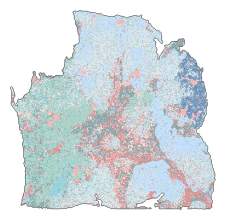

In [38]:
plot_order = list(range(len(df_plot.seurat_clusters.unique())))
dimplot_inhouse(df_plot, 'seurat_clusters', f'', plot_order, legend=False)

### We found that Cluster5 were aggregate together and corresponds to the location of TLS on the H&E (Hematoxylin and Eosin) staining.

{5: '#F0918E', 'other': '#f0f0f0'}


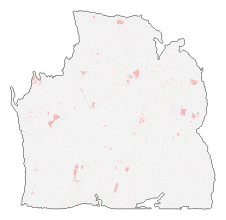

In [39]:
used_clusters = [5]
used_colors = [mycolor16[x] for x in used_clusters] + ['#f0f0f0']
df_plot['plot_item'] = [x if x in used_clusters else 'other' for x in df_plot['seurat_clusters']]
dimplot_inhouse(df_plot, 'plot_item', f'', used_clusters+['other'], cols=used_colors, legend=False)

### The Cluster5 also express *PTPRC* which represent lymphocytes

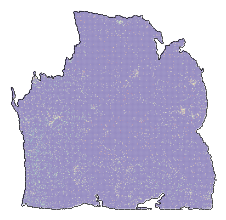

In [40]:
cm = plt.cm.Spectral_r
featureplot_inhouse(df_plot, 'PTPRC', f'')

### Next, we will validate whether Cluster5 can represent the distribution of TLS by using TLS gene sets and chemokine gene sets.

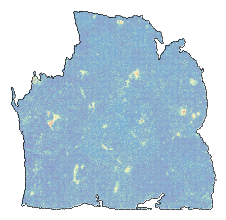

In [41]:
featureplot_inhouse(df_plot, 'Chemokine1', f'')

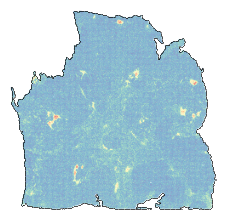

In [42]:
featureplot_inhouse(df_plot, 'TLS_Score1', f'')

### we can also validate the result use co-expressing module identified by Hotspot

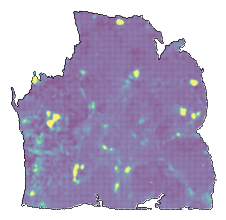

In [43]:
cm = plt.cm.viridis
featureplot_inhouse(df_plot, 'Hotspot_c1', f'')

### In order to filter out diffused pseudo-spots within Cluster 5, we applied the OPTICS algorithm to group pseudo-spot in Cluster 5 and selected pseudo-spots that are aggregate together

In [44]:
from sklearn.cluster import OPTICS
from collections import Counter

In [45]:
df_c5 = df_plot[df_plot['seurat_clusters'] == 5]
array_pos = df_c5[['row', 'col']].values
array_pos

array([[130,  25],
       [ 41, 159],
       [117,  59],
       ...,
       [263, 202],
       [ 49, 237],
       [129,  11]])

In [46]:
clustering = OPTICS(min_samples=9, max_eps=13, metric='minkowski').fit(array_pos)

In [47]:
dic_clustering = dict(zip(df_c5.index, clustering.labels_))
df_c5['optics'] = df_c5.index.map(dic_clustering)
df_c5['optics_infor'] = ['Aggregated' if x != -1 else 'Diffused' for x in df_c5['optics']]

{'Aggregated': '#e41a1c', 'Diffused': '#377eb8'}


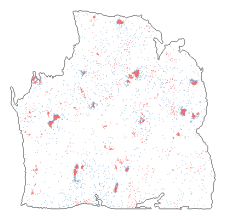

In [48]:
dimplot_inhouse(df_c5, 'optics_infor', f'/data/yuchen_data/Stereo_seq/All_Figures/TLS_identification/optics', ['Aggregated', 'Diffused'], cols=['#e41a1c', '#377eb8'], legend=False)